In this notebook, I will be using a catboost model with the rounded dataset, but I will be doing some preprocessing to the dataset to see if I can improve the model. The target will still be raw classification, and no forecasting, as this will likely form the foundation of any forecasting models.

In [7]:
import pandas as pd

train = pd.read_csv('../data/train_with_rounded_score.csv')
test = pd.read_csv('../data/test_with_rounded_score.csv')
validation = pd.read_csv('../data/validation_with_rounded_score.csv')

print(train['score'].value_counts())
print(test['score'].value_counts())
print(validation['score'].value_counts())

0    1652230
1     466944
2     295331
3     196802
4     106265
5      39224
Name: score, dtype: int64
0    247720
1     42486
2     22159
3      9590
4      3578
5       807
Name: score, dtype: int64
0    220516
1     56389
2     28498
3     12334
4      4577
5       918
Name: score, dtype: int64


We can see that all three of our datasets are heavily skewed towards 0 (no drought) being the most common class. Therefore, balanced dataset subsampling maybe needed. 

In [8]:
train.columns

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score'],
      dtype='object')

According to the dataset provider these columns correspond to the following:

- fips : US County FIPS code
- date : observation date
- PRECTOT : total precipitation (mm)
- PS : surface pressure (kPa)
- QV2M : specific humidity at 2 meters (g/kg)
- T2M : temperature at 2 meters (C)
- T2MDEW : Dew/Frost Point at 2 meters (C)
- T2MWET : Wet Bulb Temperature at 2 meters (C)
- T2M_MAX : Maximum temperature at 2 meters (C)
- T2M_MIN : Minimum temperature at 2 meters (C)
- T2M_RANGE : Range of temperature at 2 meters (C)
- TS : Earth skin temperature (C)
- WS10M : wind speed at 10 meters (m/s)
- WS10M_MAX : Maximum wind speed at 10 meters (m/s)
- WS10M_MIN : Minimum wind speed at 10 meters (m/s)
- WS10M_RANGE : Range of wind speed at 10 meters (m/s)
- WS50M : wind speed at 50 meters (m/s)
- WS50M_MAX : Maximum wind speed at 50 meters (m/s)
- WS50M_MIN : Minimum wind speed at 50 meters (m/s)
- WS50M_RANGE : Range of wind speed at 50 meters (m/s)
- score : drought score (0-5)

PRECTOT-WS50M_RANGE are the weather features, and score is the target. However, the FIPS code and the date are not true numerical features. The FIPS code is a categorical feature, and the date is a time series feature. Therefore, for this model, we will drop these two columns, and use the rest of the features as numerical features.

In [9]:
train = train.drop(['fips','date'], axis=1)
test = test.drop(['fips','date'], axis=1)
validation = validation.drop(['fips','date'], axis=1)

In [4]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


We will first try pure undersampling and pure oversampling to address the class imbalance

In [5]:
from imblearn.under_sampling import RandomUnderSampler
r = RandomUnderSampler(random_state=42)
train_X_undersample, train_Y_undersample = r.fit_resample(train.drop(['score'], axis=1), train['score']) 

In [6]:
print(train_Y_undersample.value_counts())

0    39224
1    39224
2    39224
3    39224
4    39224
5    39224
Name: score, dtype: int64


In [7]:
from imblearn.over_sampling import RandomOverSampler
r = RandomOverSampler(random_state=42)
train_X_oversample, train_Y_oversample = r.fit_resample(train.drop(['score'], axis=1), train['score'])

In [15]:
print(train_Y_oversample.value_counts())

1    1652230
2    1652230
3    1652230
4    1652230
5    1652230
0    1652230
Name: score, dtype: int64


Train on the two datasets

In [8]:
from catboost import CatBoostClassifier

oversample_model = CatBoostClassifier()
oversample_model.fit(train_X_oversample, train_Y_oversample, verbose=False)

undersample_model = CatBoostClassifier()
undersample_model.fit(train_X_undersample, train_Y_undersample, verbose=False)

In [ ]:
#save the oversample and undersample models
import pickle

with open('../models/oversample_model_rounded_catboost.pkl', 'wb') as f:
    pickle.dump(oversample_model, f)

with open('../models/undersample_model_rounded_catboost.pkl', 'wb') as f:
    pickle.dump(undersample_model, f)

Evaluate the two models

In [10]:
import pickle
from catboost import CatBoostClassifier
import pandas as pd
#load two models from saved pickles
with open('../models/oversample_model_rounded_catboost.pkl', 'rb') as f:
    oversample_model = pickle.load(f)

with open('../models/undersample_model_rounded_catboost.pkl', 'rb') as f:
    undersample_model = pickle.load(f)

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

oversample_model_preds = oversample_model.predict(test.drop(['score'], axis=1))
undersample_model_preds = undersample_model.predict(test.drop(['score'], axis=1))

oversample_confusion_matrix = confusion_matrix(test['score'], oversample_model_preds)
undersample_confusion_matrix = confusion_matrix(test['score'], undersample_model_preds)

In [12]:
oversample_model_preds.shape

(326340, 1)

In [13]:
undersample_model_preds.shape

(326340, 1)

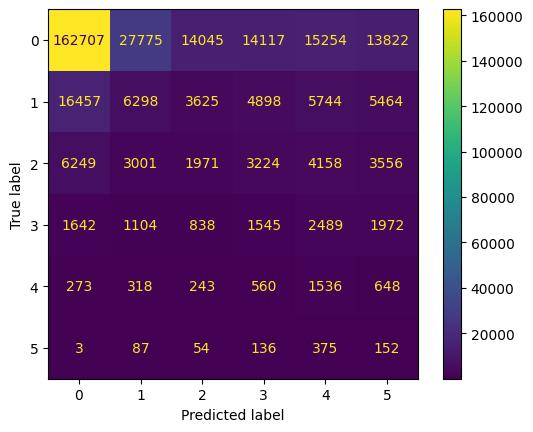

In [14]:
import matplotlib.pyplot as plt
ConfusionMatrixDisplay(oversample_confusion_matrix).plot()
plt.show()

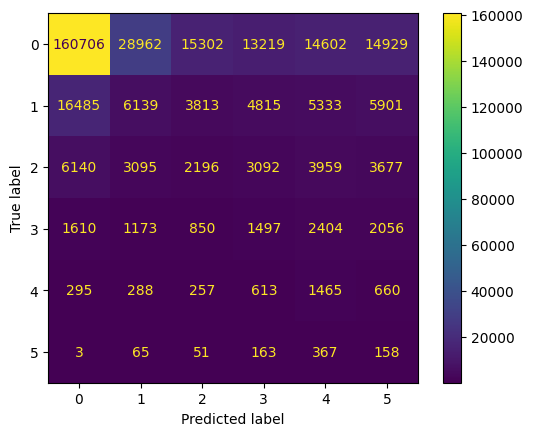

In [15]:
ConfusionMatrixDisplay(undersample_confusion_matrix).plot()
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

print('Oversample Model')
print(classification_report(test['score'], oversample_model_preds))
print('F1 score:' , f1_score(test['score'], oversample_model_preds, average='weighted'))
print('Precision: ', precision_score(test['score'], oversample_model_preds, average='weighted'))
print('Recall: ', recall_score(test['score'], oversample_model_preds, average='weighted'))


print('\nUndersample Model')
print(classification_report(test['score'], undersample_model_preds))
print('F1 score:' , f1_score(test['score'], undersample_model_preds, average='weighted'))
print('Precision: ', precision_score(test['score'], undersample_model_preds, average='weighted'))
print('Recall: ', recall_score(test['score'], undersample_model_preds, average='weighted'))

Oversample Model
              precision    recall  f1-score   support

           0       0.87      0.66      0.75    247720
           1       0.16      0.15      0.16     42486
           2       0.09      0.09      0.09     22159
           3       0.06      0.16      0.09      9590
           4       0.05      0.43      0.09      3578
           5       0.01      0.19      0.01       807

    accuracy                           0.53    326340
   macro avg       0.21      0.28      0.20    326340
weighted avg       0.69      0.53      0.60    326340

F1 score: 0.597961290636231
Precision:  0.6894385147063787
Recall:  0.5338266838266839

Undersample Model
              precision    recall  f1-score   support

           0       0.87      0.65      0.74    247720
           1       0.15      0.14      0.15     42486
           2       0.10      0.10      0.10     22159
           3       0.06      0.16      0.09      9590
           4       0.05      0.41      0.09      3578
         

Even with these sampling techniques, we didn't achieve much of a boost in performance. While we do see improvements in all three key metrics, we still have a ways to go. We can try to use additional sophistications in sampling, but we likely will have to do additional feature engineering to boost classification performance significantly. 

A potential hypothesis of something we could do is include spatial context. The data points are coming from all over the country, and it is likely that the weather patterns in one county are not the same as the weather patterns in another county. Therefore, we can try to add some spatial context to the model, or segregate the data by locality. We can also try to simplify the problem to a binary classification problem, and see if that helps.

Another idea is that we could experiment with alternative model types. Currently, we have only used GB Trees (from the Catboost family), which could theoretically be limiting model performance.